In [4]:
# https://www.tensorflow.org/tutorials/text/transformer
# https://arxiv.org/abs/2001.08317
# https://arxiv.org/pdf/1907.00235

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
# get historical daily price
symbol = 'SPY'
ticker = yf.Ticker(symbol)
history = ticker.history(period="max")
print(ticker.ticker,history.shape)

SPY (7020, 7)


In [38]:
df = pd.DataFrame()
df['price'] = history.Close
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
df['ret_mean'] = df.log_ret.rolling(21).mean()
df['hist_vol'] = df.log_ret.rolling(21).std()*np.sqrt(252)*100
df = df.dropna()
df['z_vol']=np.clip(scipy.stats.zscore(df.hist_vol)/10,-1,1)
df['z_ret']=np.clip(scipy.stats.zscore(df.ret_mean)/10,-1,1)

In [39]:
np.mean(df.hist_vol),np.std(df.hist_vol)

(28.708940585250854, 14.866293469702915)

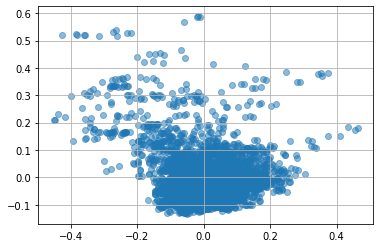

In [40]:
plt.scatter(df.z_ret,df.z_vol,alpha=0.5)
plt.grid(True)

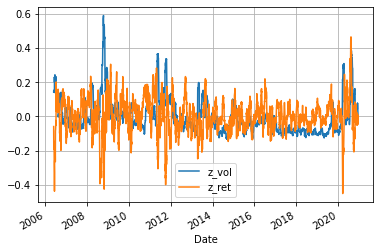

In [41]:
df[['z_vol','z_ret']].plot()
plt.grid(True)

In [10]:
# objectiv
# given x year span of z_vol, z_ret, predict next y day z_vol and z_ret

In [115]:

def etl(history):
    df = pd.DataFrame()
    df['price'] = history.Close
    df.index = history.index
    df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
    df['ret_mean'] = df.log_ret.rolling(21).mean()
    df['hist_vol'] = df.log_ret.rolling(21).std()*np.sqrt(252)*100
    df = df.dropna()
    df['z_vol']=np.clip(scipy.stats.zscore(df.hist_vol)/10,-1,1)
    df['z_ret']=np.clip(scipy.stats.zscore(df.ret_mean)/10,-1,1)
    df['month']=df.index.month.values/12
    df['day']=df.index.day.values/31
    # add in interest rate.
    return np.stack([df.z_vol.values,df.z_ret.values,df.month.values,df.day.values],axis=-1)

#look_back=252
#look_forward=40
look_back=125
look_forward=10
total_days = look_back+look_forward-1
def chunckify(arr):
    tmp_list = []
    for x in np.arange(total_days,arr.shape[0]-total_days,5):
        tmp = arr[x:x+total_days]
        if tmp.shape != (total_days,4):
            continue
        x,y = tmp[:-1*look_forward,:],tmp[-1*look_forward:,:]
        tmp_list.append((x,y))
    return tmp_list


final_list = []
symbols = ['IWM','SPY','QQQ','GLD','SLV']
ticker_list = yf.Tickers(' '.join(symbols))
for ticker in ticker_list.tickers:
    history = ticker.history(period="max")
    print(ticker.ticker,history.shape)
    arr = etl(history)
    if arr.shape[0] > total_days:
        tmp_list = chunckify(arr)
        final_list.extend(tmp_list)

IWM (5173, 7)
SPY (7023, 7)
QQQ (5481, 7)
GLD (4048, 7)
SLV (3686, 7)


In [116]:
len(final_list),final_list[0][0].shape,final_list[0][1].shape

(4795, (124, 4), (10, 4))

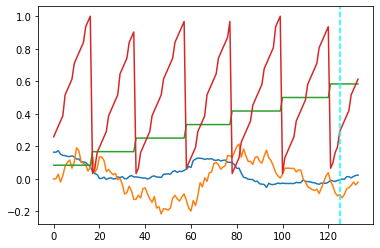

In [117]:
a=final_list[0][0]
b=final_list[0][1]
plt.plot(np.concatenate([a,b]))
plt.axvline(look_back,linestyle='--',color='cyan')

In [89]:
#https://www.tensorflow.org/tutorials/text/transformer
#http://jalammar.github.io/illustrated-transformer

In [96]:
import tensorflow as tf

inputs = tf.random.normal([32, 20, 4])
gru = tf.keras.layers.GRU(1024)
output = gru(inputs)
print(output.shape)



batch_size = 32
vocab_size=64
embedding_dim = 1024
rnn_units = 1024

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    
])
output = model.predict(inputs)

print(output.shape)

ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:277 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/recurrent.py:654 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer gru_20 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [32, 20, 4, 1024]


In [97]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
#(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, 
loss = tf.keras.losses.MeanAbsoluteError()
model.compile(optimizer=opt, loss=loss)

In [98]:
X = np.stack([x[0] for x in final_list])
y = np.stack([x[1] for x in final_list])
print(X.shape,y.shape)

(4805, 124, 4) (4805, 5, 4)


In [99]:
model.fit(X,y,epochs=40,verbose=1)

Epoch 1/40


ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:277 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/recurrent.py:654 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer gru_20 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 124, 4, 1024]


In [ ]:
#b = model.predict(a)
model.predict(a)